### Exploratory Data Analysis on Windows Logon Data

** Objective: **

The dataset is used for this analysis is especially failed windows logon data. 
<br>Demo is focussed to introduce basic data analysis in python against log data source and plotting visualization to find abnormalities in the trend

**** Investigation :  ****
 - Analyze and indentify any inconsistency in failed logon trend
 - Find the user and check what has changed in failed logon trend
 - Investigate further activity from the user and hosts in scope before and after trend changes

## Global Parameters to Configure (TimeStamp, Host, User for Investigation)

In [2]:
FilteredComputer="WIN-DC01"
FilteredAccount = "SRVACCNT-01"
startdate = 'ago(10d)'
#startdate= '\'2018-01-01\''
enddate = 'now()'
#enddate= '\'2018-01-15\''

## Connection to Log Data Source (Python Authentication)
Reference Blog Post on query data using Azure Data Explorer Python library: 
<br>https://docs.microsoft.com/en-us/azure/data-explorer/python-query-data

### Install the data library:
> `pip install azure-kusto-data`

### Libraries for Popular Log management/SIEM products
> **Splunk** : `pip install splunk-sdk`
<br>http://dev.splunk.com/python

> **Elasticsearch** : `pip install elasticsearch`
<br>https://elasticsearch-py.readthedocs.io/en/master/

> **HuntLib** : `pip install huntlib`
    <br>Common threat hunting data analysis operations : https://github.com/target/huntlib
    <br>The `huntlib` module provides two major object classes as well as a few convenience functions.
    <br>**ElasticDF**: Search Elastic and return results as a Pandas DataFrame
    <br>**SplunkDF**: Search Splunk and return results as a Pandas DataFrame
    <br>**entropy() / entropy_per_byte()**: Calculate Shannon entropy
    <br>**promptCreds()**: Prompt for login credentials in the terminal or from within a Jupyter notebook.
    <br>**edit_distance()**: Calculate how "different" two strings are from each other


### Possible ways to retrieve credentials:
> Store and read from environment variable after activating conda environment
> <br>Store and read from static config file from filesystem which will be under auditing
> <br>Store and read from Secret vault or other password stores using certificate based access
> <br>Prompt user the password and store value until the session/kernel shutdonw


In [26]:
# importing kusto libraries
from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.exceptions import KustoServiceError
from azure.kusto.data.helpers import dataframe_from_result_table


######################################################
##              AUTHENTICATION                      ##
######################################################

# Provide values respective to your cluster configuration
cluster = "<insert here your cluster name>"
client_id = "<insert here your AAD application id>"
client_secret = "<insert here your AAD application key>"
authority_id = "<insert here your AAD tenet id>"
database = "<insert here your database name>"

#making kusto connection string builder client
kcsb = KustoConnectionStringBuilder.with_aad_application_key_authentication(
    cluster, client_id, client_secret, authority_id
)
client = KustoClient(kcsb)

### Importing python libraries and set global styling parameters

In [4]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.set_option('display.max_colwidth', -1)

In [1]:
#sample query against log data source
winlogonquery = '''
windowslogons 
| where startdate < {} and enddate > {}
| where EventId == "Microsoft-Windows-Security-Auditing:4625"
| summarize LogonCount=count(),SourceCount=dcount(sourceAddress), HostCount=dcount(destinationAddress) by AccountName,Date
'''
#Formatting Query String to pass global arguments and also replace newline characters
winlogonquery= winlogonquery.format(enddate,startdate).replace('\n', '')
#executing query against the database using client object
response = client.execute(database, winlogonquery)
#creating dataframe from result table
winlogonquery_df = dataframe_from_result_table(response.primary_results[0])

### Printing Dataset schema

In [15]:
winlogonquery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
Date           41 non-null object
AccountName    41 non-null object
HostCount      41 non-null int64
SourceCount    41 non-null int64
LogonCount     41 non-null int64
dtypes: int64(3), object(2)
memory usage: 1.7+ KB


### Printing Sample dataset

In [21]:
winlogonquery_df.head(5)

,Date,AccountName,HostCount,SourceCount,LogonCount
0,3/28/2018,ASHWIN,263,327,46448
1,3/29/2018,ASHWIN,230,320,46379
2,3/30/2018,ASHWIN,245,352,44951
3,3/31/2018,ASHWIN,261,343,44347
4,4/1/2018,ASHWIN,226,289,44971


# <font color=orange>Plotting HeatMap for failed logons using seaborn library</font>

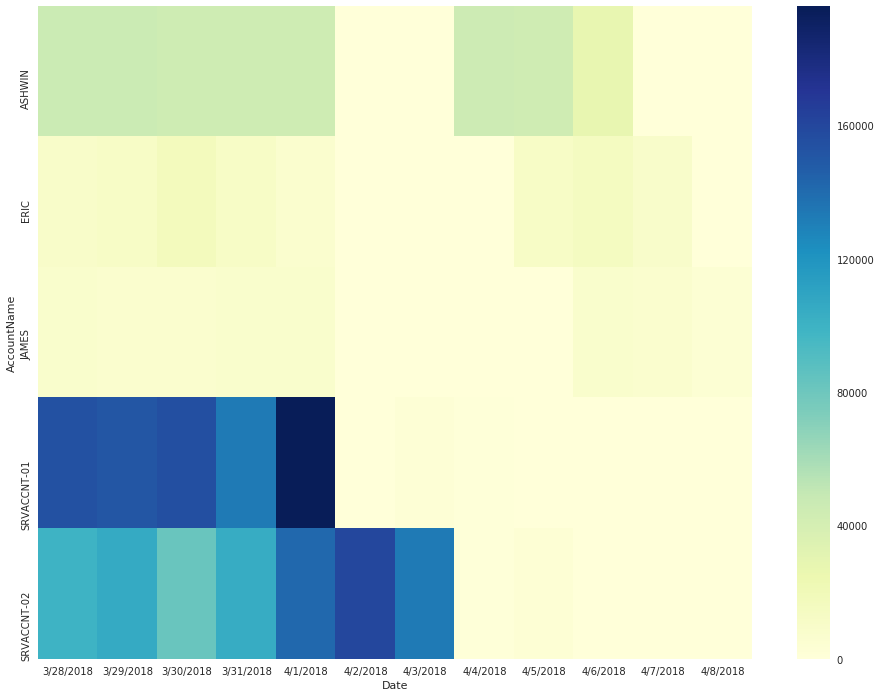

In [17]:
failedlogons_ph = winlogonquery_df.pivot(index='Date', columns='AccountName', values='LogonCount').fillna(0)
f, ax = plt.subplots(figsize=(16, 12))
hm1 = sns.heatmap(failedlogons_ph.T,cmap="YlGnBu",ax=ax)

# <font color=orange>Plotting Scatterplot for failed logons using seaborn library</font>

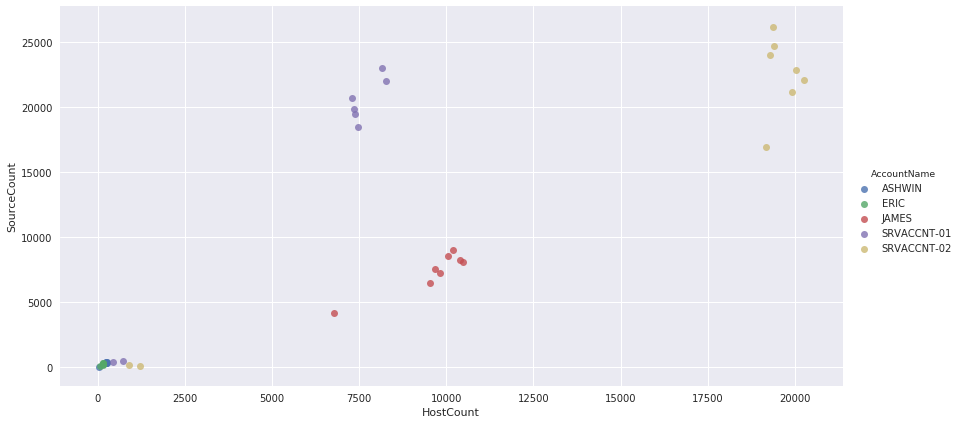

In [20]:
sns.lmplot(x='HostCount', y='SourceCount', data=winlogonquery_df,
fit_reg=False,hue='AccountName', size=6, aspect=2)

### Observations:

There is inconsistent faied logons observed with account `SRVACCNT-01` and `SRVACCNT-02` which can be further investigated for any possible successful bruteforce activity.
- From the heatmaps, high number of failed logons were observed in first 4-6 days for 2 accounts and later it significantly reduced.  
- Scatterplot also shows for `SRVACCNT-01` and `SRVACCNT-02` , failed logons were observed from high number of source addresses as compared to other accounts or for same accounts for the period of 7 days.

### Next Steps:
 - Investigate the the accounts- `SRVACCNT01` and `SRVACCNT-02`.
 - Load the logon activity for both accounts prior and after the logon trend change. you can have parameterized query for the accounts against logondataset to pull and display the details.
 - Check the succesful logons observed from the accounts and investigate activity observed from the accounts for any suspicious activities e.g. process execution, group changes, scheduled tasks, service installations etc. This can also be achieved with follow-up query for all events observed from the accounts for the mentioned days in next cell.
 - Based on the displayed cells output investigation, you can conclude if it is malicious activity or not.